# Models comparisons

In [11]:
import random

import numpy as np
from tqdm import tqdm
import torch
from scipy.stats import erlang
from project.utils.seeds import Seeds
from project.utils.Analyze import analyze_parameter, plot_comparison, compare_with_std
from project.networks.nets import DQN, Actor
from project.env_system import ManufacturingSystem

# Model parameters

In [12]:
# MODEL PARAMETRS
TEST_EPISODES = 100
OBS_SPACE = 330
ACTION_SPACE = 2
ALPHA= 0.05



#SIM PARAMETERS
SIM_DURATION= 5000
MAX_WIP= 80
ARRIVAL_TIME = 1/5.1
RANDOM_SEED= 42
EVAL_DAYS= 2500
WARMUP_PERIOD= 114
WIP_TOLERANCE= 7
DAYS_LOOKBACK= 10
N_TRACKERS= 33
SIM_TIME_STEP = 2
MIN_DUE_DATE = 77.00
MAX_DUE_DATE = 110
REWORK= 0.2
VERBOSE= False

In [13]:
# define the Seed Class
sd = Seeds()

# PUSH Model ( standard model)

In [14]:
def push_model(seed):
    # start the simulation
    sim = ManufacturingSystem(
        inter_arrival_time_distribution=lambda: random.expovariate(lambd=ARRIVAL_TIME),
        service_time_distribution=lambda x, y: erlang.rvs(5, loc=(x - 5 * (y / 5) ** (1 / 2)),
                                                          scale=(y / 5) ** (1 / 2)),
        rework_distribution=lambda: random.random() <= REWORK,
        due_dates_distribution=lambda: random.uniform(a=MIN_DUE_DATE, b=MAX_DUE_DATE),
        warmup_period=WARMUP_PERIOD,
        max_wip=MAX_WIP,
        sim_duration=SIM_DURATION,
        random_seed=seed,
        eval_days=EVAL_DAYS,
        wip_tol=WIP_TOLERANCE,
        days_lookback=DAYS_LOOKBACK,
        n_trackers=N_TRACKERS,
        verbose=VERBOSE,
        sim_time_step=SIM_TIME_STEP,
        push_model=True
    )
    
    # set results dict
    results = dict()
    results['wip'] = np.mean(sim.push_info['wip in system'])
    results['monthly throughput'] = 30 * (sim.push_info['number of job dones'] / SIM_DURATION)
    last_ea_ta_ti = sim.push_info['EA_TA_TI'][-1]
    last_ea_ta_ti = np.array(last_ea_ta_ti)
    last_ea_ta_ti = (last_ea_ta_ti / sim.push_info['number of job dones']) * 100
    
    results['EA'] = last_ea_ta_ti[0]
    results['TA'] = last_ea_ta_ti[1]
    results['TI'] = last_ea_ta_ti[2]
    results['Average time in System'] = sim.push_info['Average time in System'] 

   
    return results

In [15]:
def run_system_push(seed: int | None) -> dict:
    
    results = push_model(seed)
    return results


def main_system_push(*seeds: int):
    runs = []
    for seed in tqdm(seeds):
        run_i = run_system_push(seed)
        runs.append(run_i)

    return runs

In [16]:
push_runs = main_system_push(*sd.get_seeds(TEST_EPISODES))

100%|██████████| 100/100 [02:11<00:00,  1.31s/it]


In [17]:
sample_mean, sample_variance, half_interval = analyze_parameter(push_runs, param='wip', alpha=ALPHA)
print(f"Sample Mean: {sample_mean:.2f}")
print(f"Sample Variance: {sample_variance:.2f}")
print(f"Half Interval: {half_interval:.2f}")
print(f"Confidence Interval [{ALPHA=}]: ({sample_mean - half_interval:.2f}, {sample_mean + half_interval:.2f})")

Sample Mean: 77.32
Sample Variance: 1581.72
Half Interval: 6.60
Confidence Interval [ALPHA=0.05]: (70.72, 83.93)


# Model Company Class
Use for run a generic model based on nn.Module 

In [18]:
def model_company(best_net, model_path, seed):
    sim = ManufacturingSystem(
        inter_arrival_time_distribution=lambda: random.expovariate(lambd=ARRIVAL_TIME),
        service_time_distribution=lambda x, y: erlang.rvs(5, loc=(x - 5 * (y / 5) ** (1 / 2)),
                                                          scale=(y / 5) ** (1 / 2)),
        rework_distribution=lambda: random.random() <= REWORK,
        due_dates_distribution=lambda: random.uniform(a=MIN_DUE_DATE, b=MAX_DUE_DATE),
        warmup_period=WARMUP_PERIOD,
        max_wip=MAX_WIP,
        sim_duration=SIM_DURATION,
        random_seed=seed,
        eval_days=EVAL_DAYS,
        wip_tol=WIP_TOLERANCE,
        days_lookback=DAYS_LOOKBACK,
        n_trackers=N_TRACKERS,
        verbose=VERBOSE,
        sim_time_step=SIM_TIME_STEP
    )


    best_dict = torch.load(model_path)

    best_net.load_state_dict(best_dict['best_state_dict'])




    best_net.eval()

    # set results dict
    results = dict()
    results['wip'] = 0
    results['returns'] = 0
    results['monthly throughput'] = 0
    results['EA'] = 0
    results['TA'] = 0
    results['TI'] = 0
    results['Agent releases'] = 0
    results['PSP length'] = 0

    #  model run
    
    # reset env
    state = sim.reset()
    # set returns
    tot_reward = 0
    # continue loop until episode complete
    while True:
        # get action to take
        best_net.eval()
        action = best_net.act(state)
        # Act
        state_next, reward, terminal, truncated, info = sim.step(action)
        # update state and reward
        tot_reward += reward
        state = state_next
        if terminal:
            # add to results
            
            results['wip'] = np.mean(info['wip in system'])
            results['monthly throughput'] = 30 * (info['number of job dones'] / SIM_DURATION)
            results['Agent releases'] = info['Agent releases']
            results['PSP length'] = info['psp_list']
            results['returns'] = tot_reward
        
            last_ea_ta_ti = info['EA_TA_TI'][-1]
            last_ea_ta_ti = np.array(last_ea_ta_ti)
            last_ea_ta_ti = (last_ea_ta_ti / info['number of job dones']) * 100
        
            results['EA'] = last_ea_ta_ti[0]
            results['TA'] = last_ea_ta_ti[1]
            results['TI'] = last_ea_ta_ti[2]
        
            # End episode loop
            break

    
    return results

In [19]:
def run_system(seed: int | None, model, model_path) -> ManufacturingSystem:
    
    results = model_company(model,model_path,seed)
    return results


def main_system(*seeds: int, model, model_path):
    runs = []
    for seed in tqdm(seeds):
        run_i = run_system(seed,model,model_path)
        runs.append(run_i)

    return runs

# DDQN Model 

In [20]:
ddqn_runs = main_system(*sd.get_seeds(TEST_EPISODES),model=DQN(OBS_SPACE, ACTION_SPACE), model_path='weights/best/DDQN_testing')

100%|██████████| 100/100 [04:30<00:00,  2.70s/it]


In [21]:
sample_mean, sample_variance, half_interval = analyze_parameter(ddqn_runs,param='wip', alpha=ALPHA)
print(f"Sample Mean: {sample_mean:.2f}")
print(f"Sample Variance: {sample_variance:.2f}")
print(f"Half Interval: {half_interval:.2f}")
print(f"Confidence Interval [{ALPHA=}]: ({sample_mean - half_interval:.2f}, {sample_mean + half_interval:.2f})")

Sample Mean: 81.17
Sample Variance: 2006.32
Half Interval: 7.44
Confidence Interval [ALPHA=0.05]: (73.73, 88.60)


# Custom TD Based A2C 

In [22]:
td_a2c_runs = main_system(*sd.get_seeds(TEST_EPISODES), model=Actor(OBS_SPACE, ACTION_SPACE), model_path='weights/best/TDbasedA2C_22_06')

100%|██████████| 100/100 [04:29<00:00,  2.70s/it]


In [23]:

sample_mean, sample_variance, half_interval = analyze_parameter(td_a2c_runs,param='wip', alpha=ALPHA)
print(f"Sample Mean: {sample_mean:.2f}")
print(f"Sample Variance: {sample_variance:.2f}")
print(f"Half Interval: {half_interval:.2f}")
print(f"Confidence Interval [{ALPHA=}]: ({sample_mean - half_interval:.2f}, {sample_mean + half_interval:.2f})")

Sample Mean: 72.97
Sample Variance: 1807.19
Half Interval: 7.06
Confidence Interval [ALPHA=0.05]: (65.91, 80.03)


# MC Based A2C 

In [24]:
mc_a2c_runs = main_system(*sd.get_seeds(TEST_EPISODES),model=Actor(OBS_SPACE, ACTION_SPACE), model_path='weights/best/MCbasedA2C')

100%|██████████| 100/100 [04:28<00:00,  2.68s/it]


In [25]:

throughput_sample_mean_B, throughput_sample_variance_B, half_interval_B = analyze_parameter(mc_a2c_runs,param='wip', alpha=ALPHA)
print(f"WIP Sample Mean: {throughput_sample_mean_B:.2f}")
print(f"WIP Sample Variance: {throughput_sample_variance_B:.2f}")
print(f"Half Interval: {half_interval_B:.2f}")
print(f"Confidence Interval [{ALPHA=}]: ({throughput_sample_mean_B - half_interval_B:.2f}, {throughput_sample_mean_B + half_interval_B:.2f})")

WIP Sample Mean: 73.42
WIP Sample Variance: 1671.02
Half Interval: 6.79
Confidence Interval [ALPHA=0.05]: (66.64, 80.21)


# Plot comparisons

In [26]:
dict_runs = dict()
dict_runs['DDQN new'] = ddqn_runs
dict_runs['TD-based A2C'] = td_a2c_runs
dict_runs['MC-based A2C'] = mc_a2c_runs

In [27]:
dict_runs['PUSH'] = push_runs

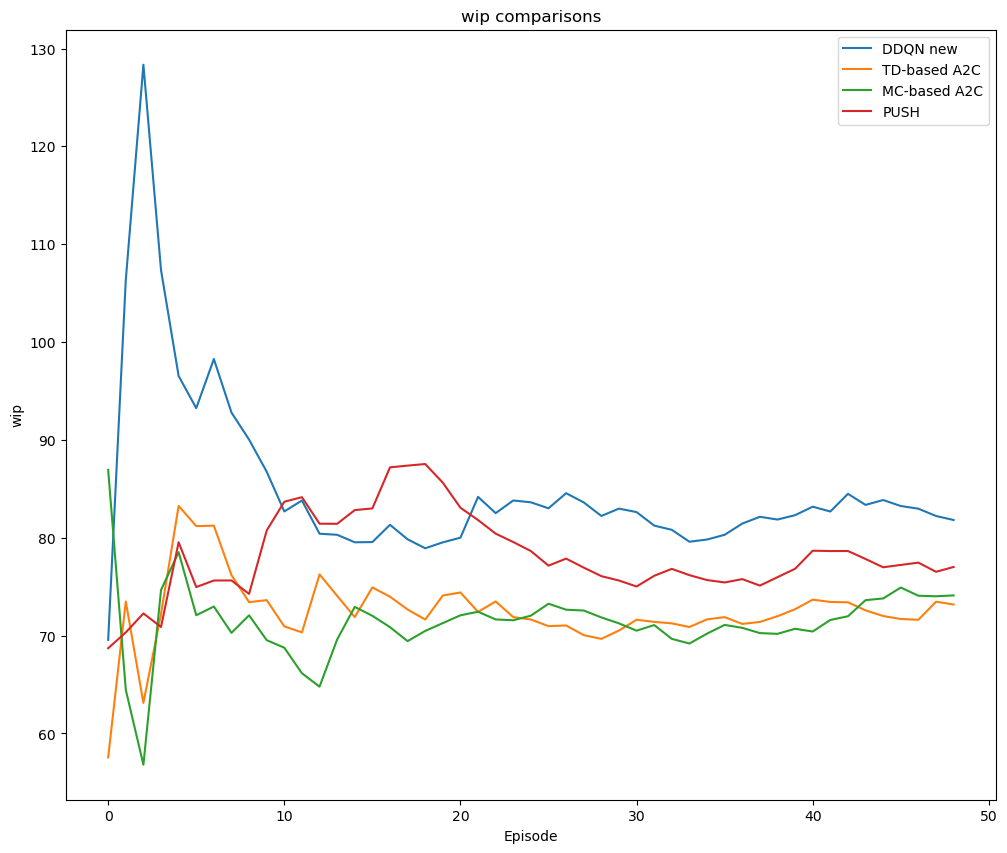

In [30]:
plot_comparison(dict_runs, param="wip",window_size=50)

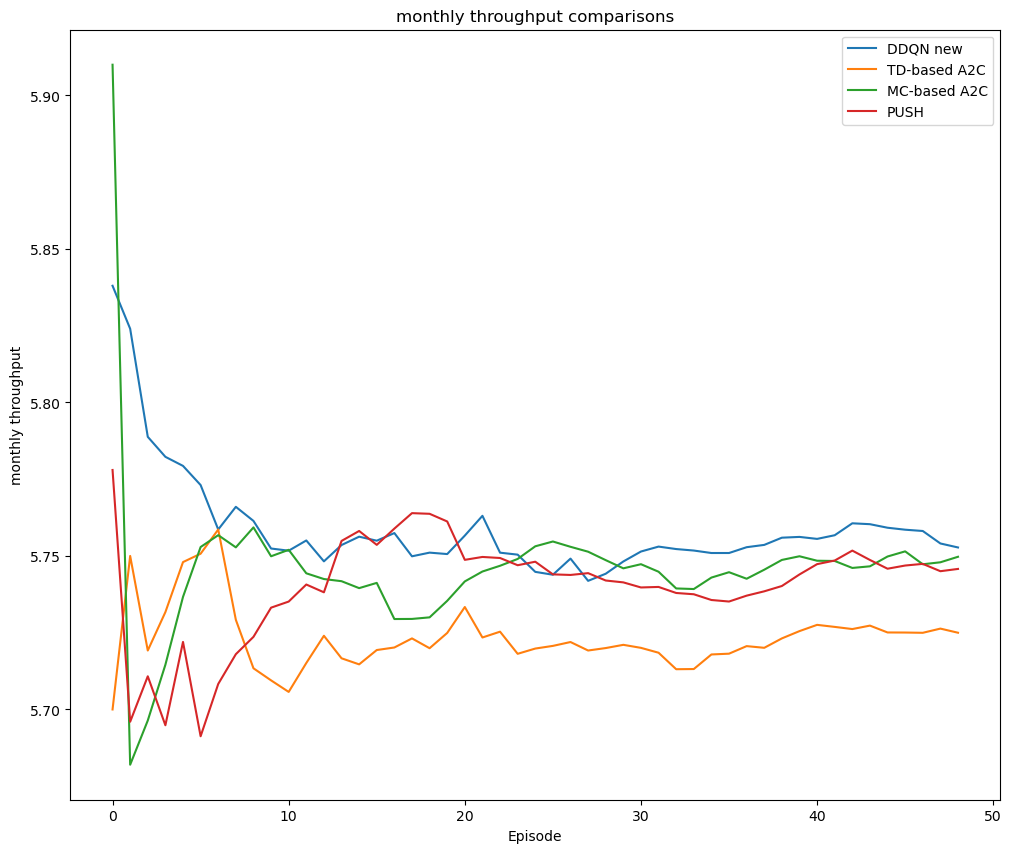

In [31]:
plot_comparison(dict_runs, param="monthly throughput", window_size=50)

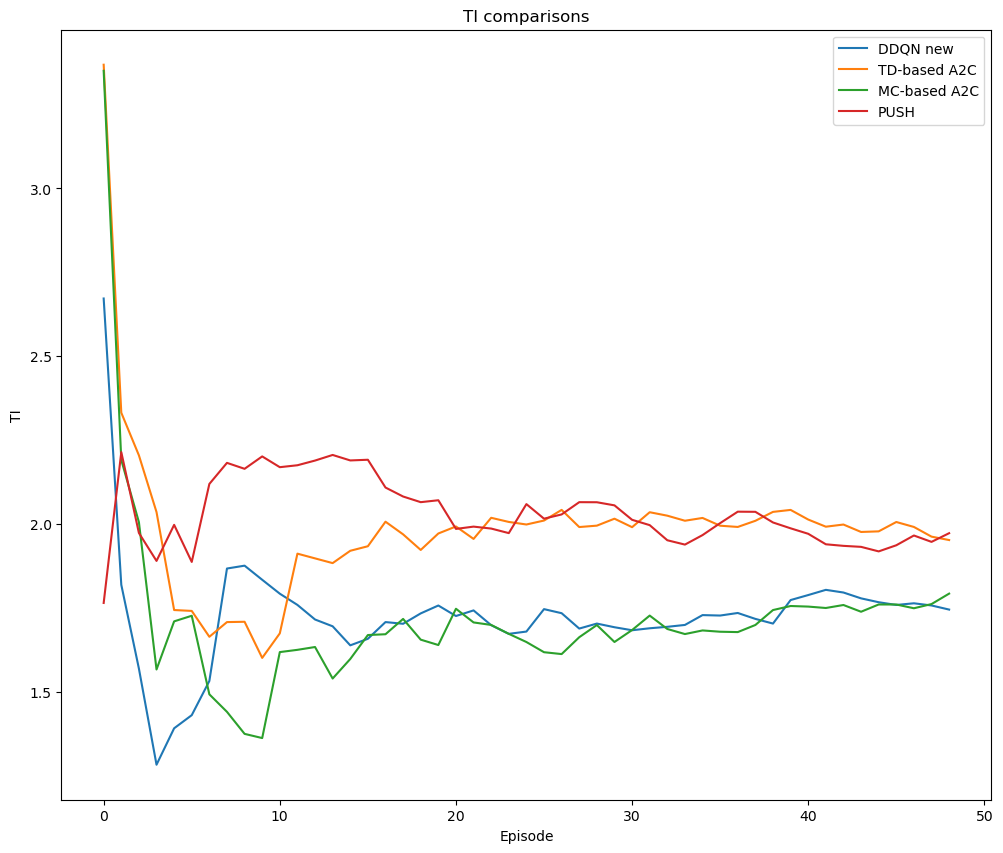

In [32]:
plot_comparison(dict_runs, param="TI", window_size=50)

In [33]:
compare_with_std(dict_runs, push_runs, param='wip')

 
----------------------------------- Model: DDQN new +++++++++++++++++++++++++++++++++++
Half interval of Model:DDQN new with respect to the standard:
-13.572002566232765, 5.886540448666655
----------------------------------- Model: DDQN new +++++++++++++++++++++++++++++++++++
----------------------------------- Model: TD-based A2C +++++++++++++++++++++++++++++++++++
Half interval of Model:TD-based A2C with respect to the standard:
-5.416683318271555, 14.11659856942785
----------------------------------- Model: TD-based A2C +++++++++++++++++++++++++++++++++++
----------------------------------- Model: MC-based A2C +++++++++++++++++++++++++++++++++++
Half interval of Model:MC-based A2C with respect to the standard:
-5.860212720148099, 13.661183817154004
----------------------------------- Model: MC-based A2C +++++++++++++++++++++++++++++++++++
----------------------------------- Model: PUSH +++++++++++++++++++++++++++++++++++
Half interval of Model:PUSH with respect to the standard:
0.

In [34]:
compare_with_std(dict_runs, push_runs, param='monthly throughput')

 
----------------------------------- Model: DDQN new +++++++++++++++++++++++++++++++++++
Half interval of Model:DDQN new with respect to the standard:
-0.037871217935726134, 0.02167121793572603
----------------------------------- Model: DDQN new +++++++++++++++++++++++++++++++++++
----------------------------------- Model: TD-based A2C +++++++++++++++++++++++++++++++++++
Half interval of Model:TD-based A2C with respect to the standard:
-0.010070138860605923, 0.04655013886060583
----------------------------------- Model: TD-based A2C +++++++++++++++++++++++++++++++++++
----------------------------------- Model: MC-based A2C +++++++++++++++++++++++++++++++++++
Half interval of Model:MC-based A2C with respect to the standard:
-0.03135676167090371, 0.025836761670903735
----------------------------------- Model: MC-based A2C +++++++++++++++++++++++++++++++++++
----------------------------------- Model: PUSH +++++++++++++++++++++++++++++++++++
Half interval of Model:PUSH with respect to the

In [35]:
compare_with_std(dict_runs, push_runs, param='TI')

 
----------------------------------- Model: DDQN new +++++++++++++++++++++++++++++++++++
Half interval of Model:DDQN new with respect to the standard:
-0.14038156643120522, 0.4434350799501351
----------------------------------- Model: DDQN new +++++++++++++++++++++++++++++++++++
----------------------------------- Model: TD-based A2C +++++++++++++++++++++++++++++++++++
Half interval of Model:TD-based A2C with respect to the standard:
-0.2820707646183837, 0.3076019593939146
----------------------------------- Model: TD-based A2C +++++++++++++++++++++++++++++++++++
----------------------------------- Model: MC-based A2C +++++++++++++++++++++++++++++++++++
Half interval of Model:MC-based A2C with respect to the standard:
-0.16269597701435753, 0.42257993709695074
----------------------------------- Model: MC-based A2C +++++++++++++++++++++++++++++++++++
----------------------------------- Model: PUSH +++++++++++++++++++++++++++++++++++
Half interval of Model:PUSH with respect to the stand